#KLक्वांटिज़ेशन

&emsp;&emsp;पिछले अनुभाग में प्रस्तुत रैखिक परिमाणीकरण को सममित परिमाणीकरण और असममित परिमाणीकरण में विभाजित किया गया है। असममित परिमाणीकरण में, डेटा में न्यूनतम और अधिकतम मान सीधे [-128, 127] पर मैप किए जाते हैं।
इसी प्रकार, सममित परिमाणीकरण सीधे डेटा के अधिकतम निरपेक्ष मान को 127 पर मैप करता है।

&emsp;&emsp;उपरोक्त दो प्रत्यक्ष मानचित्रण विधियां अपेक्षाकृत कठिन हैं, जबकि TensorRT में int8 परिमाणीकरण केएल विचलन टी के आधार पर सर्वोत्तम सीमा टी का चयन करता हैo 127 पर मैप करें। थ्रेशोल्ड टी से अधिक डेटा को सीधे थ्रेशोल्ड पर मैप किया जाएगा (ट्रंकेशन मैपिंग के समान)।

![केएल परिमाणीकरण](../images/kl_quant.png)

&emsp;&emsp;केएल विचलन का उपयोग अक्सर दो वितरणों पी और क्यू के बीच अंतर को मापने के लिए किया जाता है। केएल विचलन जितना छोटा होगा, दोनों वितरण उतने ही अधिक समान होंगे। इसका सूत्र इस प्रकार परिभाषित किया गया है:
$$
D_{KL} = \sum_{i=1}^n P(i) \log \frac{P(i)}{Q(i)}
$$

&emsp;&emsp;यदि केएल विचलन मान छोटा है, तो इसका मतलब है कि दोनों वितरण अधिक समान हैं, जिसका अर्थ है कि सीमा |T| सबसे अच्छा है।

## केएल विचलन परिमाणीकरण कार्यान्वयन चरण
1. मूल इनपुट डेटा के आधार पर 2048 बिन के साथ एक हिस्टोग्राम बनाएं
2. सर्वोत्तम विभाजन $bin_{i}$ ढूंढने के लिए [128, 2048] श्रेणी में चरण 3-5 के माध्यम से लूप करें;
3. श्रेणी [0, $bin_{i}$] में हिस्टोग्राम डेटा को मूल P के रूप में उपयोग किया जाता है, और $bin_{i}$ के बाद हिस्टोग्राम डेटा को संक्षेपित किया जाता है और $bin_{i-1}$ में जोड़ा जाता है विभाजन के रूप में $bin_{i}$ के साथ अंतिम P वितरण बनाएं।
4. क्यू वितरण बनाने के लिए पी वितरण की मात्रा निर्धारित करें (आम तौर पर, डीडिब्बे को विभाजित और मर्ज करें, और क्यू वितरण के अनुरूप डिब्बे के मूल्य के रूप में विलय के बाद औसत मूल्य की गणना करें)।
5. पी वितरण और क्यू वितरण के केएल विचलन की गणना करें।
6. न्यूनतम केएल विचलन के आधार पर सर्वश्रेष्ठ $bin_{best}$ का चयन करें, और अंतिम सीमा सीमा के रूप में $bin_{best}$ का उपयोग करें, जिसे 127 की सीमा टी पर मैप किया गया है।
7. सर्वोत्तम सीमा टी, स्केल = टी/127 के आधार पर पैमाने की गणना करें।
8. मूल डेटा की मात्रा निर्धारित करें (वजन, सक्रियण मान)।ईएस, आदि) सममित परिमाणीकरण पर आधारित है।

maximum activation value 305.47503366510796
threshold:  1537
threshold edges: 229.25779833160348


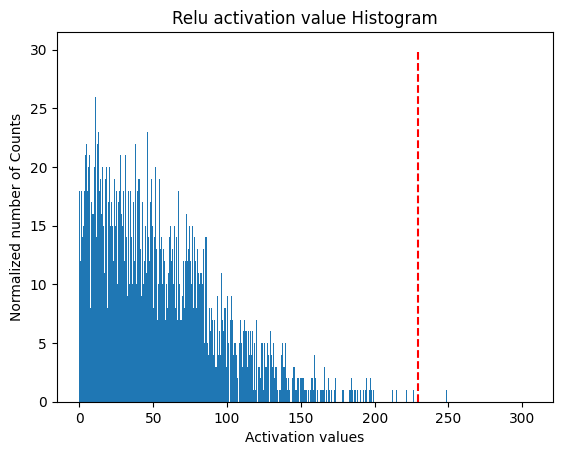

In [10]:
import random
import numpy as np
import matplotlib.pyplot as plt  
import copy
import scipy.stats as stats

# बेतरतीब ढंग से परीक्षण डेटा उत्पन्न करें
def generator_P(size):
    walk = []
    avg = random.uniform(0.000, 0.999)
    std = random.uniform(50.000, 99.999)
    for _ in range(size):
        walk.append(random.gauss(avg, std)) # 生成符合高斯分布的随机数
    return walk

# नैन मानों को रोकने के लिए चिकनी पी और क्यू, क्योंकि केएल विचलन लॉग (पी/क्यू) की गणना करेगा, और जब क्यू 0 है तो नैन दिखाई देगा
def smooth_distribution(p, eps=0.0001):
    is_zeros = (p == 0).astype(np.float32)
    is_nonzeros = (p != 0).astype(np.float32)
    n_zeros = is_zeros.sum()
    n_nonzeros = p.size - n_zeros
    if not n_nonzeros:
        raise ValueError('The discrete probability distribution is malformed. All entries are 0.')
    eps1 = eps * float(n_zeros) / float(n_nonzeros)
    assert eps1 < 1.0, 'n_zeros=%d, n_nonzeros=%d, eps1=%f' % (n_zeros, n_nonzeros, eps1)
    hist = p.astype(np.float32)
    hist += eps * is_zeros + (-eps1) * is_nonzeros
    assert (hist <= 0).sum() == 0
    return hist

def threshold_distribution(distribution, target_bin = 128):
    distribution = distribution[1:]
    length = distribution.size # 2047
    threshold_sum = sum(distribution[target_bin:]) # [128: ]
    kl_divergence = np.zeros(length - target_bin) # 初始化 2047 - 128 = 1919 个KL散度值
    
    for threshold in range(target_bin, length): # 遍历threshold寻找KL散度最低的阈值
        sliced_nd_hist = copy.deepcopy(distribution[:threshold]) # [0, threshold）内的作为P
        p = sliced_nd_hist.copy() # 生成p

        p[threshold - 1] += threshold_sum # 把 [threshold:] 后的累加和加到 p[threshold - 1] 中
        threshold_sum = threshold_sum - distribution[threshold] # 更新下一轮的累加和，即上一轮的累加和减去即将移入P分布的区间数据

        is_nonzeros = (p != 0).astype(np.int64) # [0:threshold]内不为0的区间
        
        quantized_bins = np.zeros(target_bin, dtype = np.int64) # 初始化量化后的bins
        num_merged_bins = sliced_nd_hist.size // target_bin # 计算多少个区间需要合并来计算平均值，例如最初有8个bins，需要合并到4个bins，则每两个bins需要进行合并

#डिब्बे मर्ज करें
        for j in range(target_bin): 
            start = j * num_merged_bins # 合并开始的bins
            stop = start + num_merged_bins # 合并结束的bins
            quantized_bins[j] = sliced_nd_hist[start:stop].sum() # 计算区间内bins的总和
        quantized_bins[-1] += sliced_nd_hist[target_bin * num_merged_bins:].sum()

#Q की गणना करें
        q = np.zeros(sliced_nd_hist.size, dtype = np.float64) # 初始化量化后的q
        for j in range(target_bin):
            start = j * num_merged_bins
            if j == target_bin - 1:
                stop = -1
            else:
                stop = start + num_merged_bins # 每num_merged_bins个bins进行合并组成q
            norm = is_nonzeros[start:stop].sum() # 看看合并区间里，不为0的区间个数
            if norm != 0:
                q[start:stop] = float(quantized_bins[j]) / float(norm) # 用均值（假如区间内都不为0）填充q
        
# पी और क्यू को चिकना करना
        p = smooth_distribution(p)
        q = smooth_distribution(q)
# पी और क्यू के बीच केएल विचलन की गणना करें
        kl_divergence[threshold - target_bin] = stats.entropy(p, q)

# सीमा के अनुरूप न्यूनतम केएल विचलन का सूचकांक ज्ञात करें
    min_kl_divergence = np.argmin(kl_divergence)
    threshold_value = min_kl_divergence + target_bin # 计算真正的threshold, 基于最初的128, 因为一开始就是从128开始不断向外计算来扩大P的范围

    return threshold_value

if __name__ == '__main__':
    
    int_max = 127
# परीक्षण डेटा को बेतरतीब ढंग से प्रारंभ करें
    size = 20000
    P = generator_P(size) 
    P = np.array(P)
    P = P[P > 0] # 保留大于0的数
    print("maximum activation value", max(np.absolute(P))) # 最大的激活值

    hist, bin_edges = np.histogram(P, bins = 2048) # 生成直方图 hist表示每一个bins对应的数量, bins表示截止 
    threshold = threshold_distribution(hist, target_bin = 128) # 返回KL散度最小的划分bins
    print("threshold: ", threshold)
    print("threshold edges:", bin_edges[threshold]) # 截止到threshold对应的bins, 能够表示的范围 bin_edges[-1]表示上面最大的激活值，即能够表示所有数

# पैमाने की गणना करें
    scale = bin_edges[threshold] / int_max # 即bin_edges[threshold] / 127 
    
# स्प्लिट_ज़ी समूहों में विभाजित करें, घनत्व इंगित करता है कि मानकीकृत है या नहीं
    plt.title("Relu activation value Histogram")
    plt.xlabel("Activation values")
    plt.ylabel("Normalized number of Counts")
    plt.hist(P, bins=2047)
    plt.vlines(bin_edges[threshold], 0, 30, colors = "r", linestyles = "dashed") # 红线向左就是能够表示的所有范围
    plt.show()
